In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import wosis
import pandas as pd
import metaknowledge as mk

# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

C:\Users\douglasd\AppData\Local\Continuum\miniconda3\envs\biblio\lib\site-packages\fuzzywuzzy-0.17.0-py3.6.egg\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
RC = mk.RecordCollection("tmp/rest_requested_corpora.txt")

Plot keyword trend

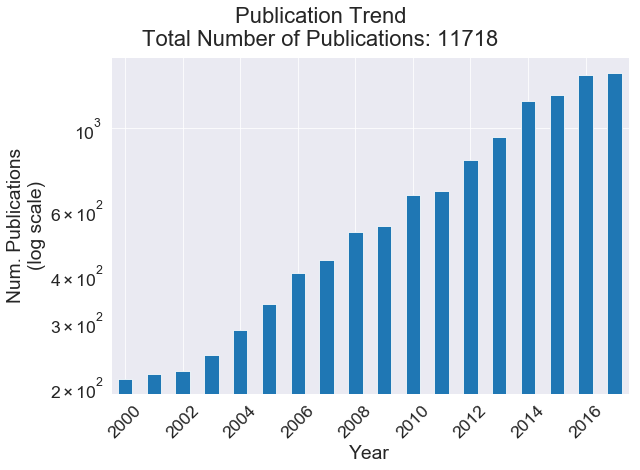

In [4]:
wos_plot.plot_pub_trend(RC, title='Publication Trend', save_plot_fn='figs/pubtrend_2000-2016.png')

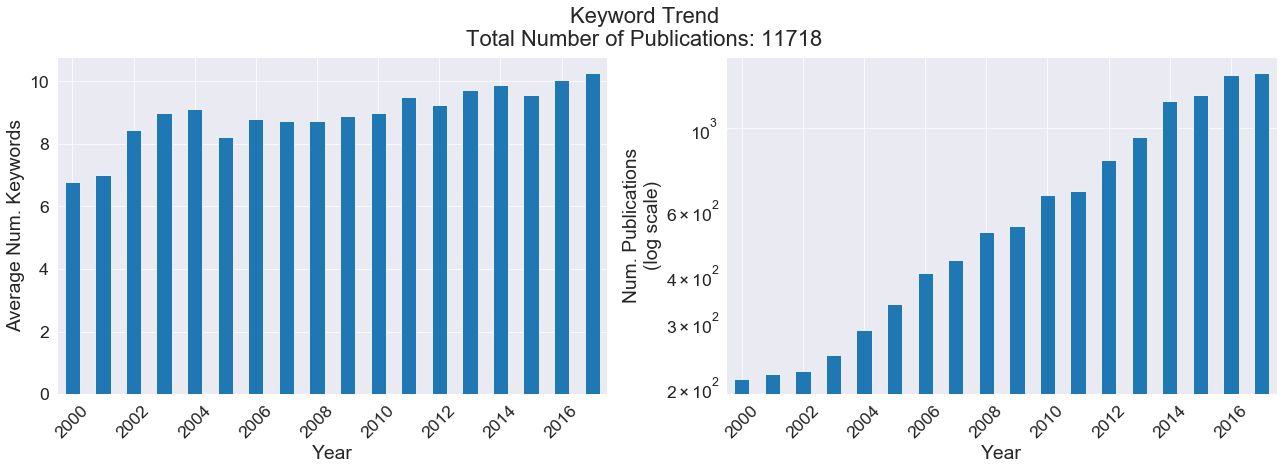

In [15]:
# Plot out the keyword trend. Can save the plot as an image if you give it a file location (will be saved in PNG format)
wos_plot.plot_kw_trend(RC, title='Keyword Trend', save_plot_fn="figs/kw_trend_2000-2016.png")

<hr>

Plot publication trend

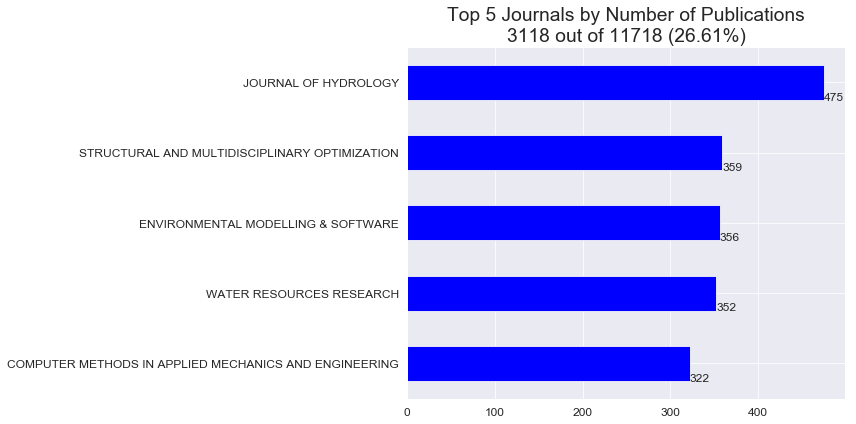

In [6]:
wos_plot.plot_pubs_per_journal(RC, top_n=5, annotate=True, show_stats=True, save_plot_fn='figs/journal_pubs.png')

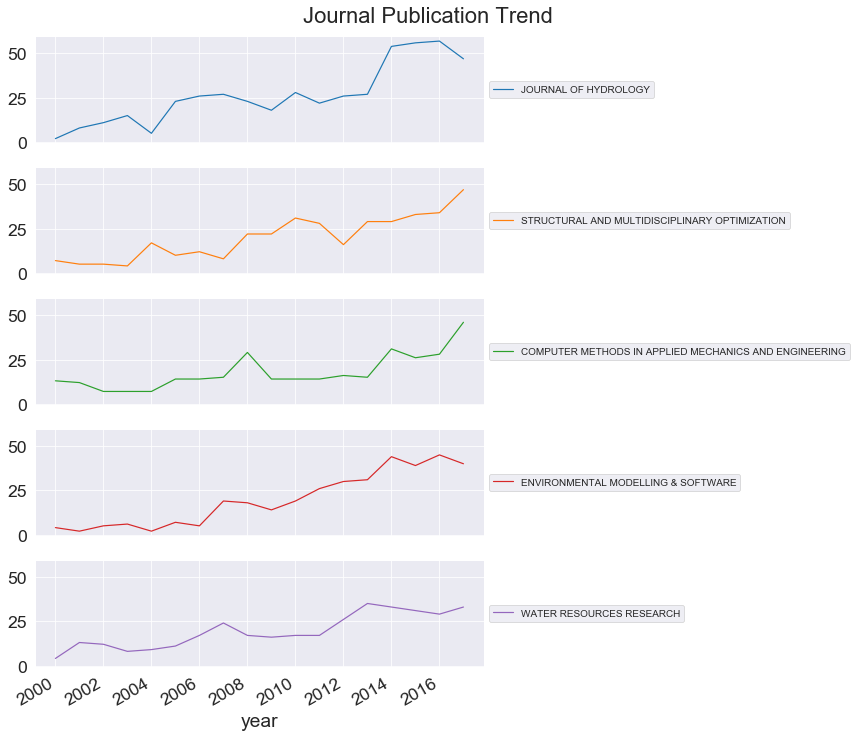

In [7]:
wos_plot.plot_journal_pub_trend(RC, top_n=5, save_plot_fn='figs/journal_pub_trend.png')

In [8]:
journals_of_interest = ['Structural and Multidisciplinary Optimization'.upper(), 'Computer Methods in Applied Mechanics and Engineering'.upper(),
                       'Water Resources Research'.upper(), 'Environmental Modelling & Software'.upper(), 'Journal of Hydrology'.upper()]
pubs_for_journals = wosis.find_pubs_by_journal(RC, journals_of_interest)

In [9]:
import glob

data_dir = "tmp"  # Using the temporary data directory
wos_config = wosis.load_config("config.yml")

# Get citations for each paper
paper_citations_per_journal = {}
for pubs in pubs_for_journals:
    fn = '{}/{}_citations.csv'.format(data_dir, pubs)
    file_list = glob.glob(fn)
    if not file_list:
        # Get citation data if not already downloaded and saved
        paper_citations_per_journal[pubs] = wosis.get_num_citations(pubs_for_journals[pubs], wos_config)
        paper_citations_per_journal[pubs].to_csv(fn)
    else:
        # If available, load the saved data
        paper_citations_per_journal[pubs] = pd.read_csv(fn)

Authenticated (SID: 6DwaKrek6AXUgizaw6c)



Authenticated (SID: 6DMNAOzLUuD28tKBTUz)



Authenticated (SID: 6DBiH4YKHxUHudRQeSy)



Authenticated (SID: 5E1pAORWQ1eNzsHAMgm)



Authenticated (SID: 8CSpApmTbJzDtLR7nS2)


In [10]:
cols_of_interest = ['AU', 'year', 'title', 'journal', 'citations', 'DOI link']
collection = pd.DataFrame(columns=cols_of_interest)
for journal, df in paper_citations_per_journal.items():
    df = wosis.link_to_pub(df)
    df['journal'] = journal
    df['DOI link'] = df['DOI link'].str.replace('envost', 'envsoft')  # fix incorrect DOI link
    collection = collection.append(df[cols_of_interest][0:10], ignore_index=True)

In [11]:
top_cited_in_top_journals = collection.sort_values('citations', ascending=False)

top_cited_in_top_journals.head(10)

,AU,year,title,journal,citations,DOI link
30,"Bennett, ND|Croke, BFW|Guariso, G|Guillaume, J...",2013,Characterising performance of environmental mo...,ENVIRONMENTAL MODELLING & SOFTWARE,581,https://dx.doi.org/10.1016/j.envsoft.2012.09.011
31,"Campolongo, F|Cariboni, J|Saltelli, A",2007,An effective screening design for sensitivity ...,ENVIRONMENTAL MODELLING & SOFTWARE,578,https://dx.doi.org/10.1016/j.envsoft.2006.10.004
20,"Abbaspour, KC|Yang, J|Maximov, I|Siber, R|Bogn...",2007,Modelling hydrology and water quality in the p...,JOURNAL OF HYDROLOGY,560,https://dx.doi.org/10.1016/j.jhydrol.2006.09.014
21,"van Griensven, A|Meixner, T|Grunwald, S|Bishop...",2006,A global sensitivity analysis tool for the par...,JOURNAL OF HYDROLOGY,555,https://dx.doi.org/10.1016/j.jhydrol.2005.09.008
32,"Refsgaard, JC|van der Sluijs, JP|Hojberg, AL|V...",2007,Uncertainty in the environmental modelling pro...,ENVIRONMENTAL MODELLING & SOFTWARE,510,https://dx.doi.org/10.1016/j.envsoft.2007.02.004
33,"Merritt, WS|Letcher, RA|Jakeman, AJ",2003,A review of erosion and sediment transport models,ENVIRONMENTAL MODELLING & SOFTWARE,407,https://dx.doi.org/10.1016/S1364-8152(03)00078-1
0,"Sigmund, O|Maute, K",2013,Topology optimization approaches A comparative...,STRUCTURAL AND MULTIDISCIPLINARY OPTIMIZATION,382,https://dx.doi.org/10.1007/s00158-013-0978-6
34,"Saltelli, A|Annoni, P",2010,How to avoid a perfunctory sensitivity analysis,ENVIRONMENTAL MODELLING & SOFTWARE,355,https://dx.doi.org/10.1016/j.envsoft.2010.04.012
22,"Oudin, L|Hervieu, F|Michel, C|Perrin, C|Andrea...",2005,Which potential evapotranspiration input for a...,JOURNAL OF HYDROLOGY,321,https://dx.doi.org/10.1016/j.jhydrol.2004.08.026
23,"Yang, J|Reichert, P|Abbaspour, KC|Xia, J|Yang, H",2008,Comparing uncertainty analysis techniques for ...,JOURNAL OF HYDROLOGY,312,https://dx.doi.org/10.1016/j.jhydrol.2008.05.012


In [12]:
top_cited_in_top_journals.to_csv('../data/top_cited_in_top_journals.csv', index=False)